In [186]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from utils.print import print_block
from data.dataset import REFLACXWithClinicalDataset
from utils.gradcam import get_df_label_pred_img_input_loss, show_gradCAMpp_result

from tqdm.notebook import tqdm
from utils.plot import relabel_ellipse_df, get_ellipses_patch
from utils.transform import TransformFuncs
from copy import copy
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from model.xami import XAMIMultiCocatModal
from utils.gradcam import get_df_label_pred_img_input_loss, show_gradCAMpp_result
from utils.train import get_aus_loss



In [183]:
pd.options.mode.chained_assignment = None

# checking if the GPU is available
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"Will be using {device}")

In [2]:
reflacx_dataset = REFLACXWithClinicalDataset(image_size=256)

Positive Loss weight:
[0.768546   0.78635013 0.7937685  0.8338279  0.87388724]
Negative Loss weight:
[0.231454   0.21364985 0.20623146 0.1661721  0.12611276]
Random Loss:
0.21026036153991162


In [102]:
cxr_prefix = "cxr"
cxr_clinical_prefix ="cxr_clinical"

cxr_model_name = 'test_0_8162_epoch300_WithoutClincal_dim32_2022-02-07 21_43_31_353207'
cxr_clinical_model_name = 'test_0_8260__epoch300_WithClincal_dim32_2022-02-08 10_03_56_953198'

In [4]:
cxr_dfs = []
cxr_clinical_dfs = []

for id in list(reflacx_dataset.df['id']):
    cxr_dfs.append(pd.read_csv(os.path.join(f"{cxr_model_name}_result", id, 'df.csv'), index_col=0))
    cxr_clinical_dfs.append(pd.read_csv(os.path.join(f"{cxr_clinical_model_name}_result", id, 'df.csv'), index_col=0))    

In [5]:
cxr_dfs = pd.concat(cxr_dfs, axis=0)
cxr_clinical_df = pd.concat(cxr_clinical_dfs, axis=0)

In [7]:
cxr_dfs.columns

Index(['index', 'id', 'dicom_id', 'subject_id', 'stay_id', 'study_id', 'split',
       'image_path', 'ViewPosition', 'image_size_x', 'image_size_y',
       'anomaly_location_ellipses_path', 'age', 'gender', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'Airway wall thickening', 'Atelectasis', 'Consolidation',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Groundglass opacity',
       'Other', 'Pneumothorax', 'Pulmonary edema', 'Quality issue',
       'Support devices', 'Wide mediastinum', 'Abnormal mediastinal contour',
       'Acute fracture', 'Enlarged hilum', 'Hiatal hernia',
       'High lung volume / emphysema', 'Interstitial lung disease',
       'Lung nodule or mass', 'Pleural abnormality',
       'pred_Enlarged cardiac silhouette', 'pred_Atelectasis',
       'pred_Pleural abnormality', 'pred_Consolidation',
       'pred_Pulmonary edema', 'loss'],
      dtype='object')

In [8]:
all_pred_cols = [ f"pred_{col}"  for col in reflacx_dataset.labels_cols]
cxr_rename_map = {}
for pred_col in all_pred_cols:
    cxr_rename_map[pred_col] = f"{cxr_prefix}_{pred_col}"

cxr_rename_map['loss'] = f'{cxr_prefix}_loss'

In [9]:
combined_df = cxr_dfs.rename(cxr_rename_map,axis=1)

In [11]:
for pred_col in all_pred_cols:
    combined_df[f'{cxr_clinical_prefix}_{pred_col}'] = cxr_clinical_df[pred_col]

combined_df[f'{cxr_clinical_prefix}_loss'] = cxr_clinical_df['loss']

In [ ]:
combined_df[f'{cxr_prefix}_accuaracy'] = combined_df.apply(lambda x: accuracy_score(
    np.array(x[[f"{col}" for col in reflacx_dataset.labels_cols]]).astype('long'),
    (np.array(x[[f"{cxr_prefix}_{col}" for col in all_pred_cols]]) > 0.5).astype('long'),
), axis=1)


combined_df[f'{cxr_clinical_prefix}_accuaracy'] = combined_df.apply(lambda x: accuracy_score(
    np.array(x[[f"{col}" for col in reflacx_dataset.labels_cols]]).astype('long'),
    (np.array(x[[f"{cxr_clinical_prefix}_{col}" for col in all_pred_cols]]) > 0.5).astype('long'),
), axis=1)

In [14]:
combined_df.head(5)

index           id                                      dicom_id  \
0      0  P102R108387  34cedb74-d0996b40-6d218312-a9174bea-d48dc033   
0      1  P102R379837  34cedb74-d0996b40-6d218312-a9174bea-d48dc033   
0      2  P102R558314  34cedb74-d0996b40-6d218312-a9174bea-d48dc033   
0      3  P102R765317  34cedb74-d0996b40-6d218312-a9174bea-d48dc033   
0      4  P102R915878  34cedb74-d0996b40-6d218312-a9174bea-d48dc033   

   subject_id   stay_id  study_id  split  \
0    18111516  32067002  55032240  train   
0    18111516  32067002  55032240  train   
0    18111516  32067002  55032240  train   
0    18111516  32067002  55032240  train   
0    18111516  32067002  55032240  train   

                                          image_path ViewPosition  \
0  D:\XAMI-MIMIC\patient_18111516\CXR-JPG\s550322...           AP   
0  D:\XAMI-MIMIC\patient_18111516\CXR-JPG\s550322...           AP   
0  D:\XAMI-MIMIC\patient_18111516\CXR-JPG\s550322...           AP   
0  D:\XAMI-MIMIC\patient_18111516\CXR-JPG\s550322...           AP   
0  D:\XAMI-MIMIC\patient_18111516\CXR-JPG\s550322...           AP   

   image_size_x  ...  cxr_pred_Pleural abnormality cxr_pred_Consolidation  \
0          2544  ...                      0.008908               0.017632   
0          2544  ...                      0.008908               0.017632   
0          2544  ...                      0.008908               0.017632   
0          2544  ...                      0.008908               0.017632   
0          2544  ...                      0.008908               0.017632   

   cxr_pred_Pulmonary edema  cxr_loss  \
0                  0.075871  0.874296   
0                  0.075871  0.874296   
0                  0.075871  0.874296   
0                  0.075871  0.372869   
0                  0.075871  0.874296   

   cxr_clinical_pred_Enlarged cardiac silhouette  \
0                                       0.967592   
0                                       0.967592   
0                                       0.967592   
0                                       0.967592   
0                                       0.967592   

   cxr_clinical_pred_Atelectasis  cxr_clinical_pred_Pleural abnormality  \
0                       0.145157                               0.042499   
0                       0.145157                               0.042499   
0                       0.145157                               0.042499   
0                       0.145157                               0.042499   
0                       0.145157                               0.042499   

   cxr_clinical_pred_Consolidation  cxr_clinical_pred_Pulmonary edema  \
0                         0.010186                           0.195144   
0                         0.010186                           0.195144   
0                         0.010186                           0.195144   
0                         0.010186                           0.195144   
0                         0.010186                           0.195144   

   cxr_clinical_loss  
0           0.729233  
0           0.729233  
0           0.729233  
0           0.226389  
0           0.729233  

[5 rows x 54 columns]

In [51]:
# get the best and worst cases.

cxr_highest_loss_idxs = [list(reflacx_dataset.df.index).index(idx)  for idx in list(combined_df.sort_values(
    f'{cxr_prefix}_loss', ascending=False)[:5]["index"])]


cxr_lowest_accuracy_idxs = [list(reflacx_dataset.df.index).index(idx) for idx in list(combined_df.sort_values(
    f'{cxr_prefix}_accuracy', ascending=True)[:5]["index"])]


cxr_clinical_highest_loss_idxs = [list(reflacx_dataset.df.index).index(idx)  for idx in list(combined_df.sort_values(
    f'{cxr_clinical_prefix}_loss', ascending=False)[:5]["index"])]


cxr_clinical_lowest_accuracy_idxs = [list(reflacx_dataset.df.index).index(idx) for idx in list(combined_df.sort_values(
    f'{cxr_clinical_prefix}_accuracy', ascending=True)[:5]["index"])]

In [187]:
# load models

cxr_model = XAMIMultiCocatModal(
    reflacx_dataset,
    device,
    use_clinical=False,
    model_dim=32, # was 64
    embeding_dim=64,
    dropout=.2,  # increase the dropout rate did improve the regularization.
    pretrained=True
)
cxr_model.load_state_dict(torch.load(os.path.join('saved_models', cxr_model_name ), map_location=device))
cxr_model.to(device)


cxr_clinical_model = XAMIMultiCocatModal(
    reflacx_dataset,
    device,
    use_clinical=True,
    model_dim=32, # was 64
    embeding_dim=64,
    dropout=.2,  # increase the dropout rate did improve the regularization.
    pretrained=True
)
cxr_clinical_model.load_state_dict(torch.load(os.path.join('saved_models', cxr_clinical_model_name), map_location=device))
cxr_clinical_model.to(device)


# load loss function
loss_fn = get_aus_loss(reflacx_dataset)


In [234]:
best_worst_cases = {}

for col in reflacx_dataset.labels_cols:
    best_worst_cases[col] ={}

    sorted_df = (combined_df[combined_df[col]].sort_values(f"{cxr_prefix}_pred_{col}", ascending=False))[:5]

    best_worst_cases[col][f'{cxr_prefix}_best']= [list(reflacx_dataset.df.index).index(idx) for idx in list((combined_df[combined_df[col]].sort_values(f"{cxr_prefix}_pred_{col}", ascending=False))[:5]["index"])]

    best_worst_cases[col][f'{cxr_prefix}_worst']= [list(reflacx_dataset.df.index).index(idx) for idx in list((combined_df[combined_df[col]].sort_values(f"{cxr_prefix}_pred_{col}", ascending=True))[:5]["index"])]


    best_worst_cases[col][f'{cxr_clinical_prefix}_best']= [list(reflacx_dataset.df.index).index(idx) for idx in list((combined_df[combined_df[col]].sort_values(f"{cxr_clinical_prefix}_pred_{col}", ascending=False))[:5]["index"])]

    best_worst_cases[col][f'{cxr_clinical_prefix}_worst']= [list(reflacx_dataset.df.index).index(idx) for idx in list((combined_df[combined_df[col]].sort_values(f"{cxr_clinical_prefix}_pred_{col}", ascending=True))[:5]["index"])]



In [68]:
def plot_predicting_info(model, idx, disease,loss_fn):

    df, labels_df, pred_df, img, loss, model_input = get_df_label_pred_img_input_loss(model, loss_fn, reflacx_dataset, idx, device)

    for l_col in reflacx_dataset.labels_cols:
        df[f"pred_{l_col}"] = None
        df.at[0, f"pred_{l_col}"] = pred_df.at[0, l_col]

    df.at[0, 'loss'] = loss

    display(df)

    ellipse_df = pd.read_csv(df['anomaly_location_ellipses_path'].iloc[0])
    relabeled_ellipse_df = relabel_ellipse_df(ellipse_df)

    model_input_image_size = reflacx_dataset.image_size
    
    image_size_x = df.iloc[0]['image_size_x']
    image_size_y = df.iloc[0]['image_size_y']

    ellipes = get_ellipses_patch(relabeled_ellipse_df, d, image_size_x, image_size_y, model_input_image_size)

    # fig, ax = plt.subplots(1, figsize=(10, 10), dpi=80, sharex=True)
    # ax.imshow(TransformFuncs.display_transform(img))

    # for e in ellipes:
    #     ax.add_patch(copy(e))

    ## plot the gradcam images with bouding boxes.
    gradcam_img = show_gradCAMpp_result(reflacx_dataset, model, d, img, model_input, use_full_features=True)

    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=80, sharex=True)
    ax.imshow(gradcam_img)
        
    ax.set_title(f'{d} (pred={df.at[0, f"pred_{d}"]:.4f}, label={df.at[0, d]})')

    for e in ellipes:
        ax.add_patch(copy(e))

    plt.show()

            # plt.close('all')

        ## store prediction data and loss as well.

        # df.to_csv(os.path.join(instance_save_dir, "df.csv"))


  0%|          | 0/5 [00:00<?, ?it/s]

index           id                                      dicom_id  \
0   1580  P300R576522  78e763db-b5ee86ae-bc0ef22c-da34a3cb-80b76884   

   subject_id   stay_id  study_id  split  \
0    14443106  32349824  56836380  train   

                                          image_path ViewPosition  \
0  D:\XAMI-MIMIC\patient_14443106\CXR-JPG\s568363...           AP   

   image_size_x  ...  High lung volume / emphysema Interstitial lung disease  \
0          3056  ...                         False                     False   

   Lung nodule or mass  Pleural abnormality  pred_Enlarged cardiac silhouette  \
0                False                 True                          0.974405   

   pred_Atelectasis  pred_Pleural abnormality  pred_Consolidation  \
0          0.993867                  0.962756            0.989126   

   pred_Pulmonary edema      loss  
0              0.905164  3.773972  

[1 rows x 48 columns]

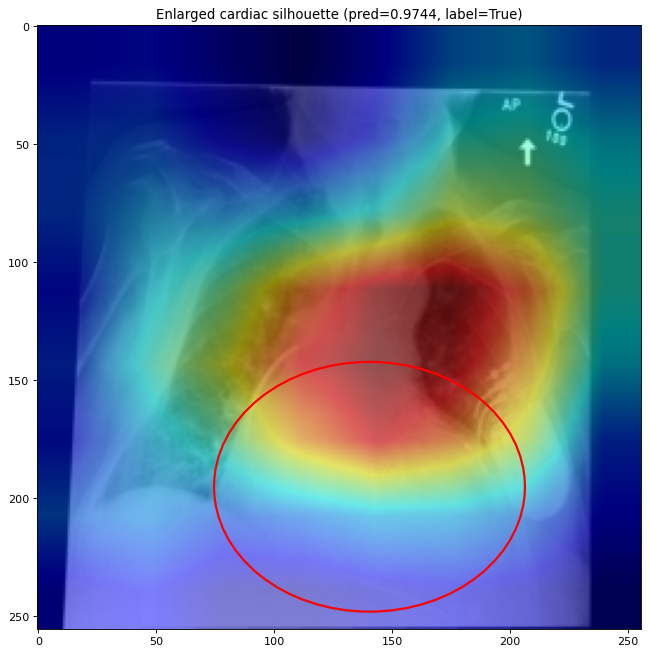

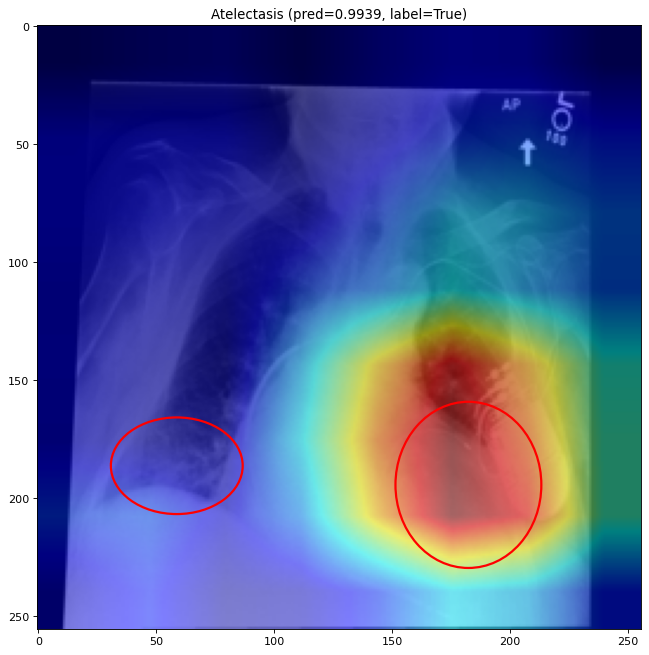

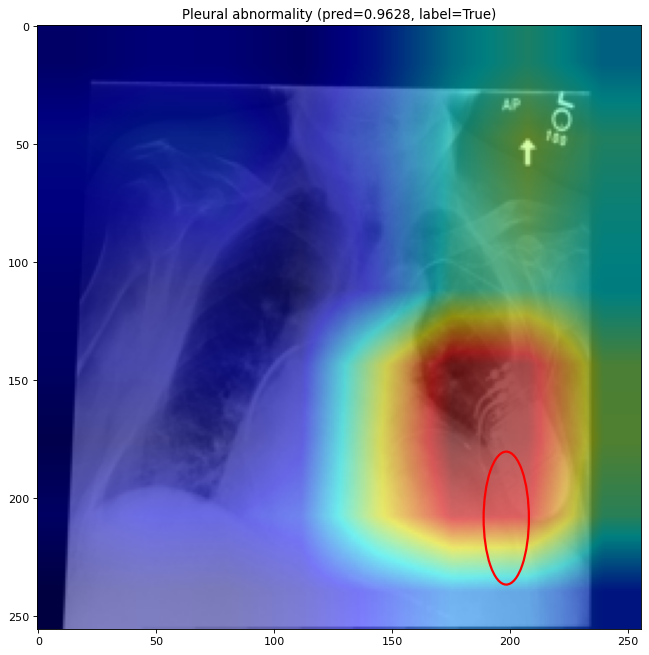

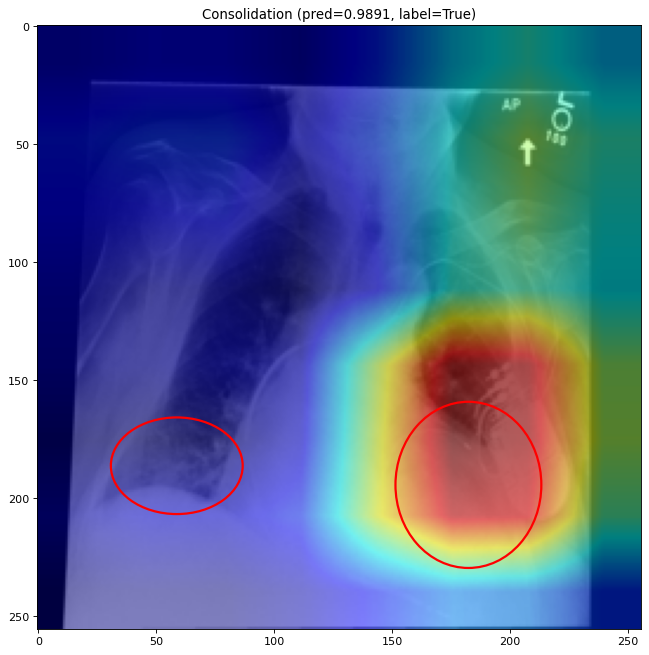

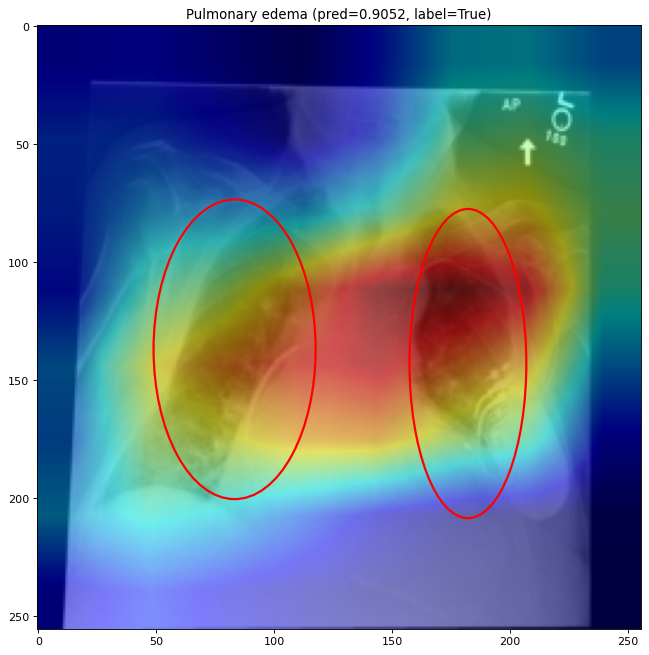

index           id                                      dicom_id  \
0   2545  P300R801796  8afc3991-7ec1912b-b24d9633-3c4b0f57-17c0e8f4   

   subject_id   stay_id  study_id  split  \
0    18087960  39432013  59570639  train   

                                          image_path ViewPosition  \
0  D:\XAMI-MIMIC\patient_18087960\CXR-JPG\s595706...           PA   

   image_size_x  ...  High lung volume / emphysema Interstitial lung disease  \
0          2544  ...                         False                     False   

   Lung nodule or mass  Pleural abnormality  pred_Enlarged cardiac silhouette  \
0                False                 True                          0.981993   

   pred_Atelectasis  pred_Pleural abnormality  pred_Consolidation  \
0          0.995239                  0.946732            0.985506   

   pred_Pulmonary edema      loss  
0              0.897553  3.745291  

[1 rows x 48 columns]

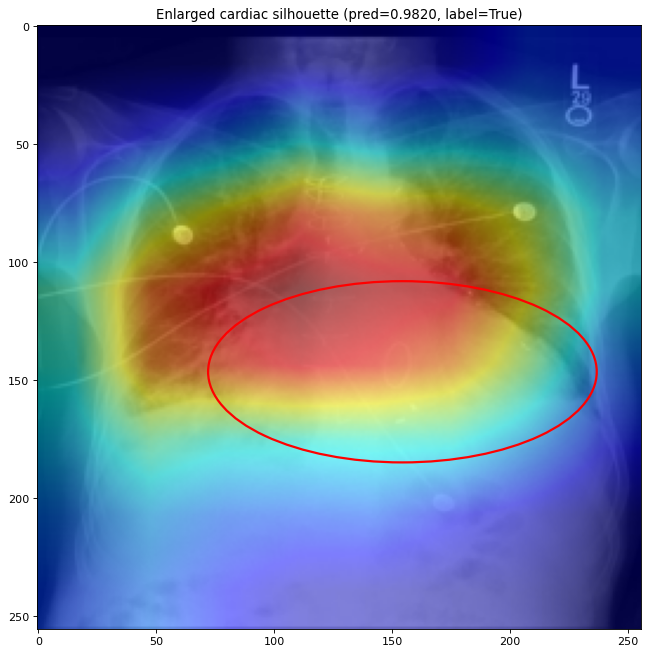

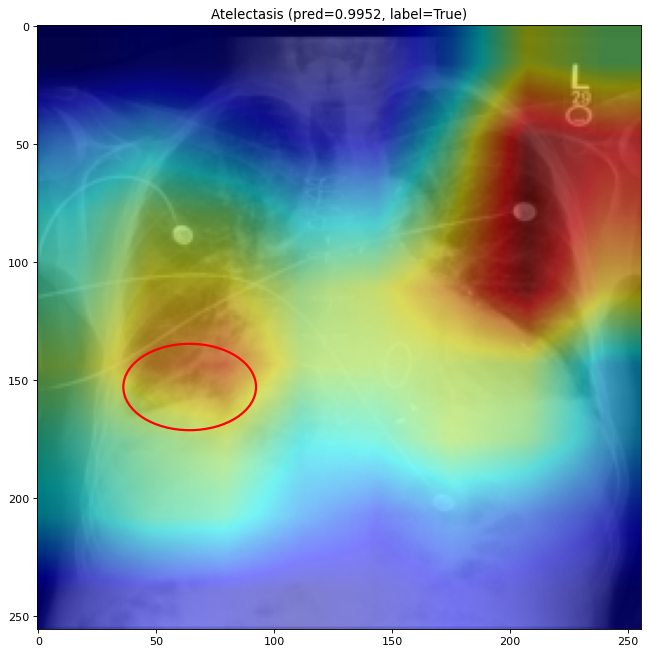

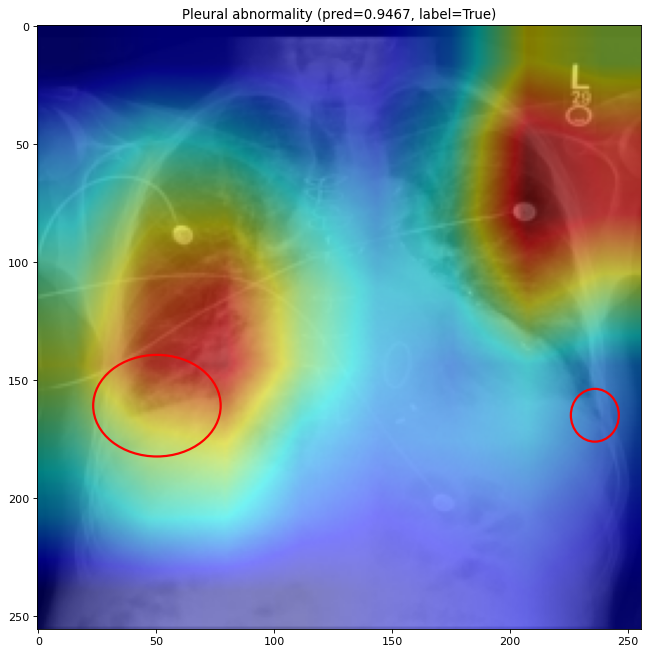

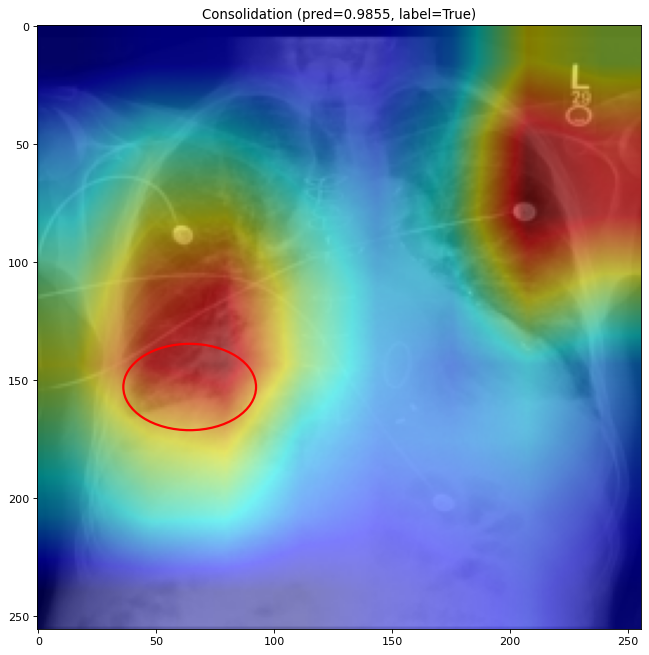

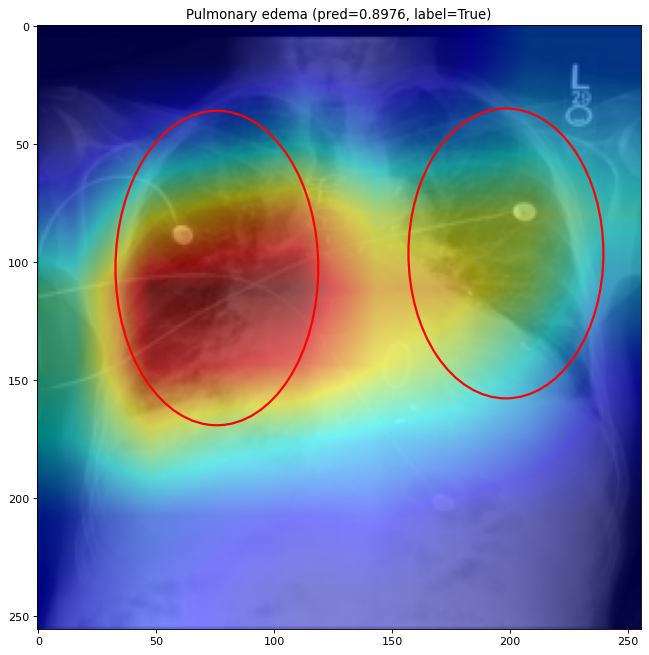

index           id                                      dicom_id  \
0    137  P129R608147  3db10b12-1c0c2273-0eb4d5ba-ea1331d9-aa0d7d3d   

   subject_id   stay_id  study_id  split  \
0    14057989  31913163  53827893  train   

                                          image_path ViewPosition  \
0  D:\XAMI-MIMIC\patient_14057989\CXR-JPG\s538278...           AP   

   image_size_x  ...  High lung volume / emphysema Interstitial lung disease  \
0          3056  ...                         False                     False   

   Lung nodule or mass  Pleural abnormality  pred_Enlarged cardiac silhouette  \
0                False                 True                          0.986629   

   pred_Atelectasis  pred_Pleural abnormality  pred_Consolidation  \
0           0.99566                  0.920938            0.980174   

   pred_Pulmonary edema     loss  
0              0.902566  3.71387  

[1 rows x 48 columns]

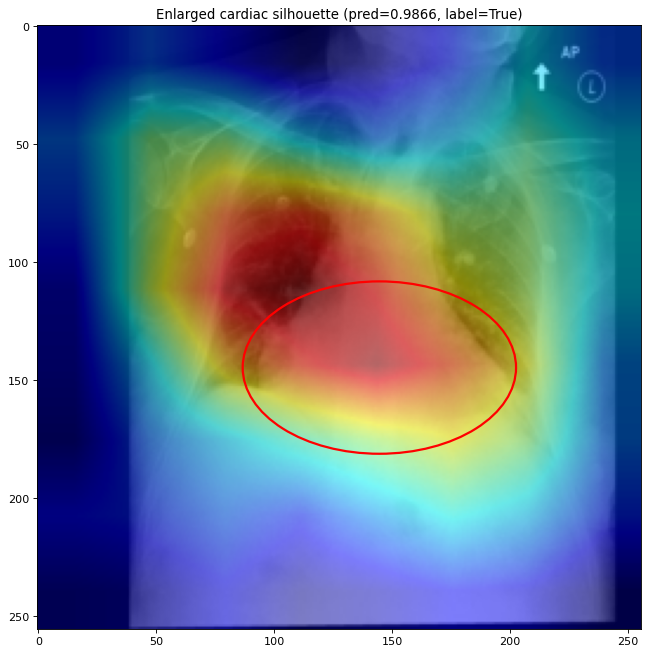

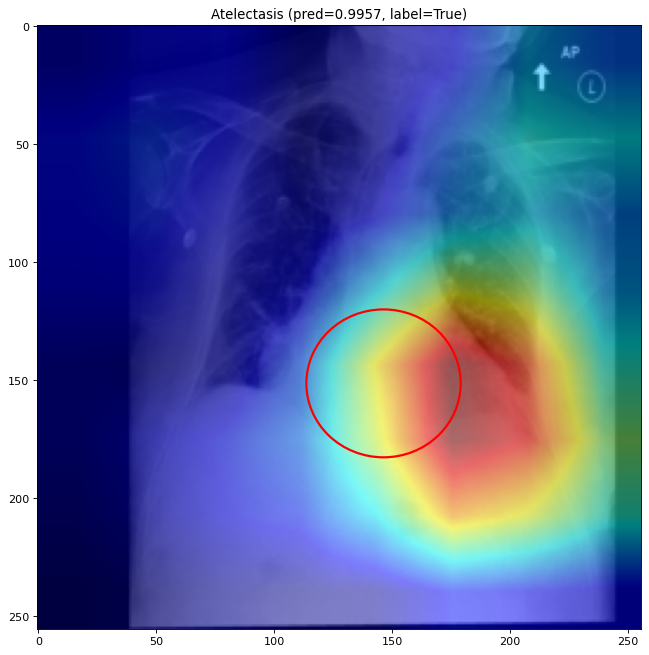

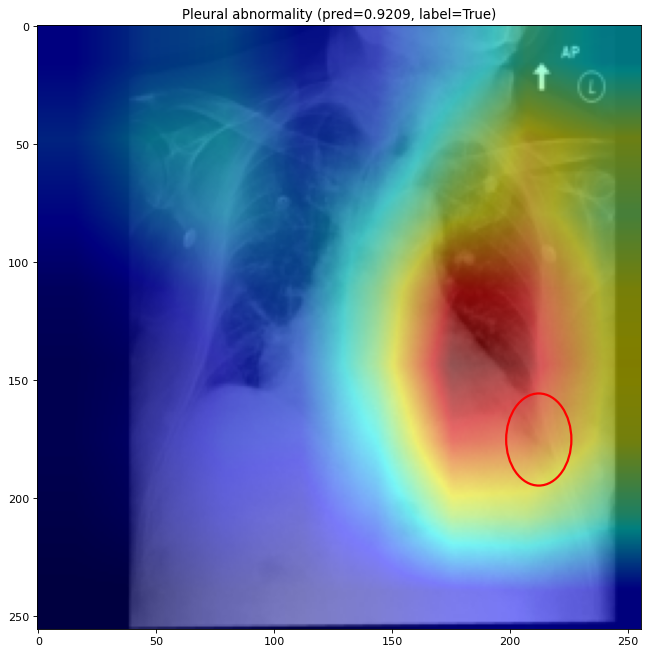

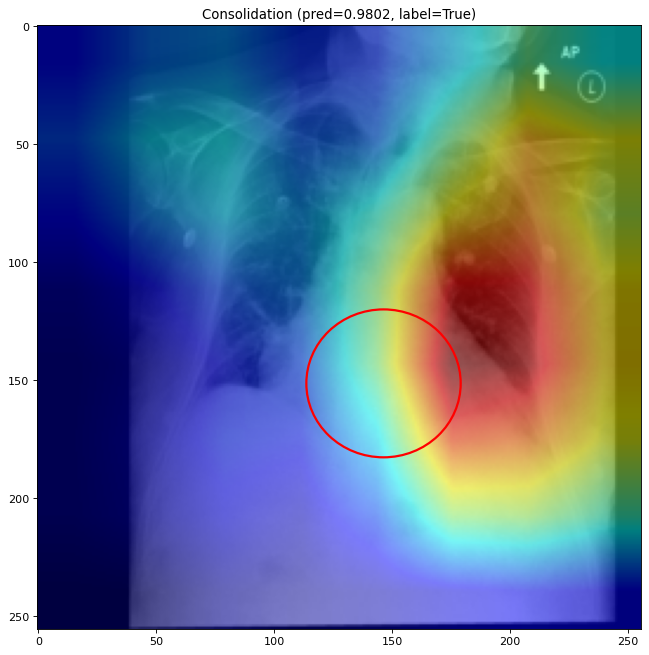

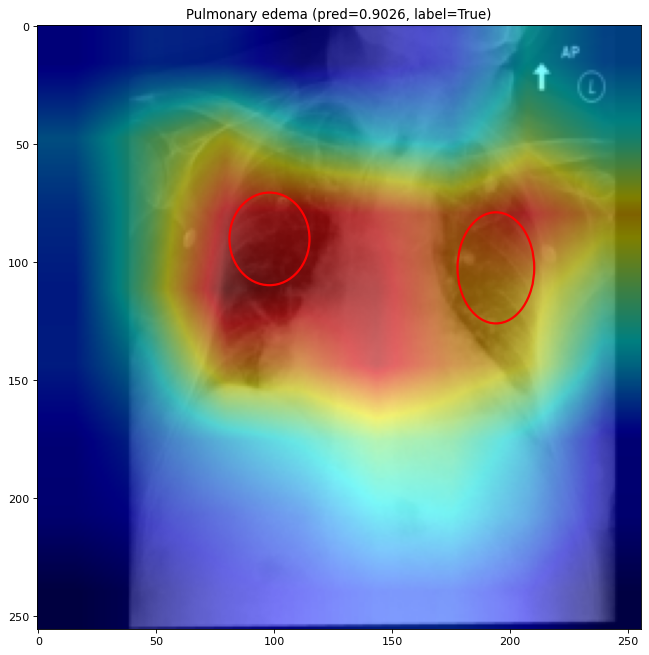

index           id                                      dicom_id  \
0   1123  P300R660662  12e57f0c-d65e3fa6-68fa7a62-1205a028-af0105be   

   subject_id   stay_id  study_id  split  \
0    12478288  39853494  50847530  train   

                                          image_path ViewPosition  \
0  D:\XAMI-MIMIC\patient_12478288\CXR-JPG\s508475...           AP   

   image_size_x  ...  High lung volume / emphysema Interstitial lung disease  \
0          2544  ...                         False                     False   

   Lung nodule or mass  Pleural abnormality  pred_Enlarged cardiac silhouette  \
0                False                 True                          0.964945   

   pred_Atelectasis  pred_Pleural abnormality  pred_Consolidation  \
0           0.99187                  0.972355            0.990853   

   pred_Pulmonary edema      loss  
0              0.897968  3.262912  

[1 rows x 48 columns]

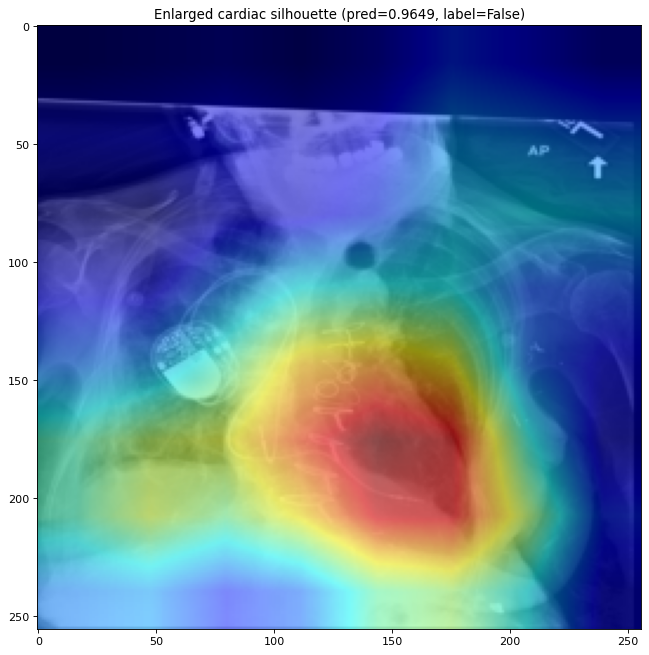

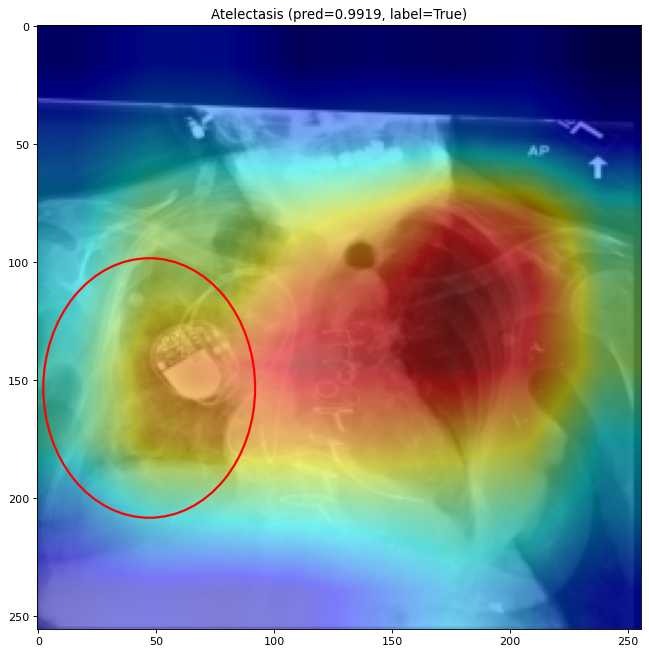

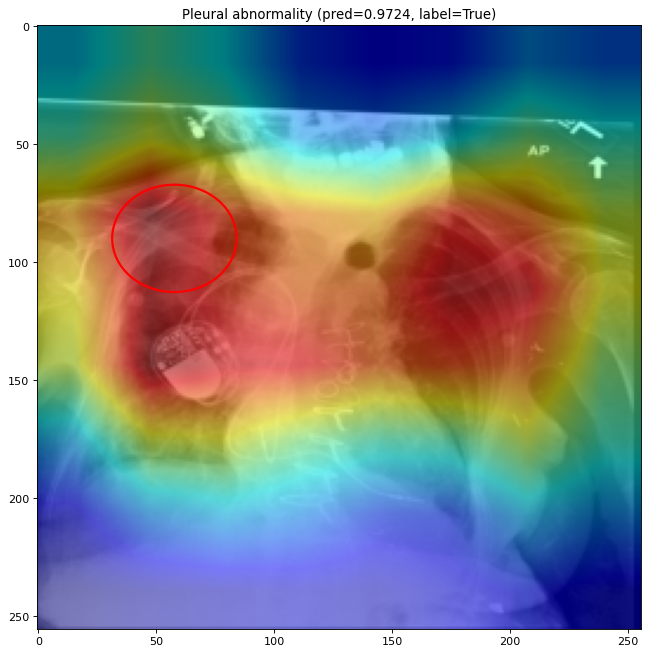

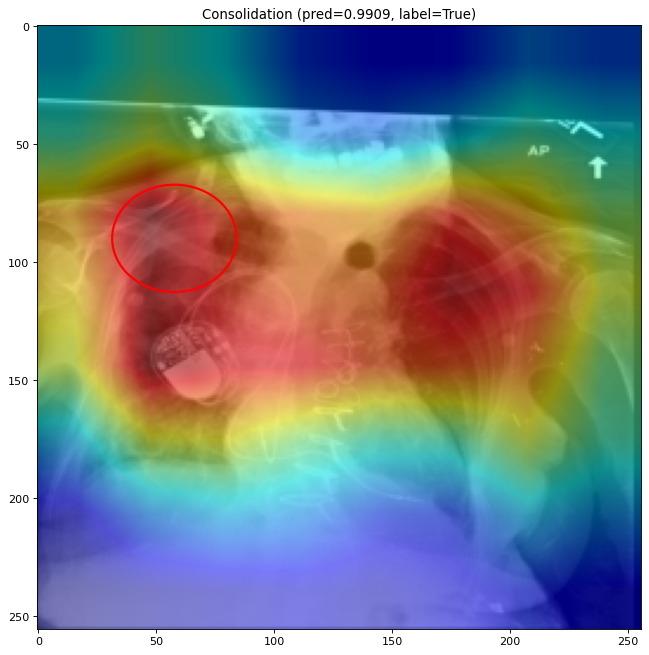

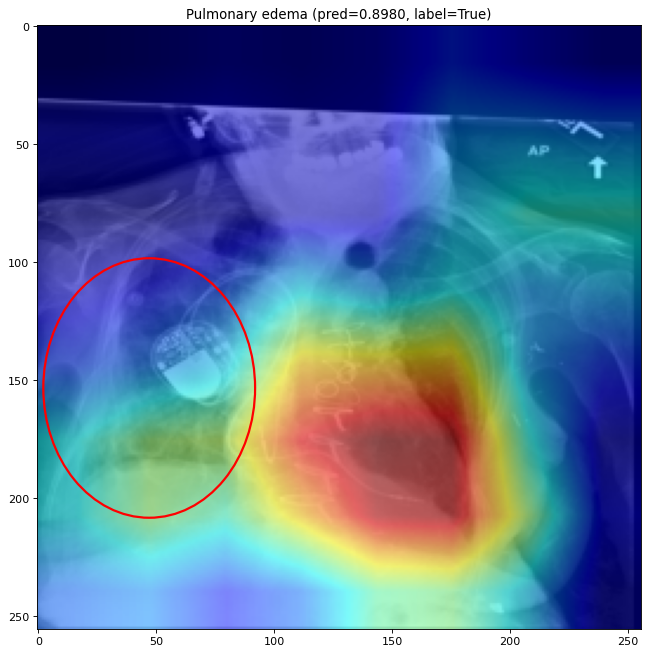

index           id                                      dicom_id  \
0   2226  P300R603281  d2e3dff5-381ea801-b587e5f8-7a35a88a-9c9b66a5   

   subject_id   stay_id  study_id split  \
0    16826047  31264685  54920051  test   

                                          image_path ViewPosition  \
0  D:\XAMI-MIMIC\patient_16826047\CXR-JPG\s549200...           AP   

   image_size_x  ...  High lung volume / emphysema Interstitial lung disease  \
0          2544  ...                         False                     False   

   Lung nodule or mass  Pleural abnormality  pred_Enlarged cardiac silhouette  \
0                False                 True                          0.963782   

   pred_Atelectasis  pred_Pleural abnormality  pred_Consolidation  \
0          0.992314                  0.973958            0.991174   

   pred_Pulmonary edema      loss  
0               0.89242  3.257415  

[1 rows x 48 columns]

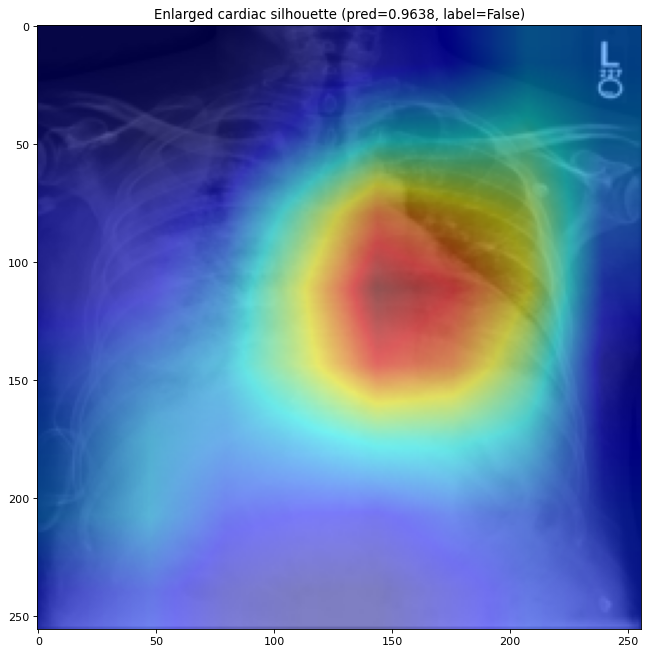

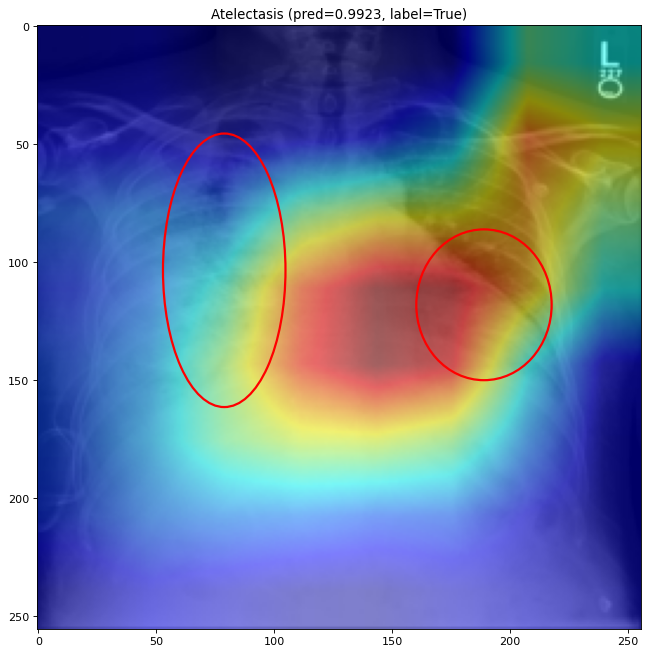

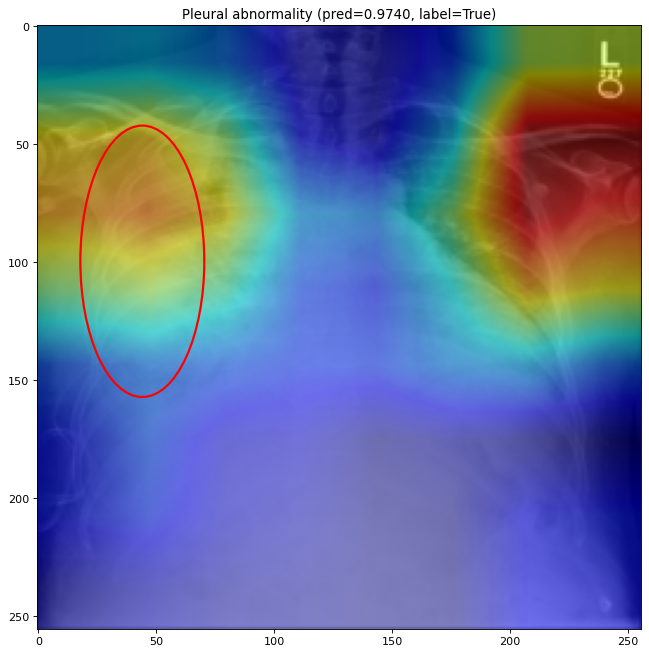

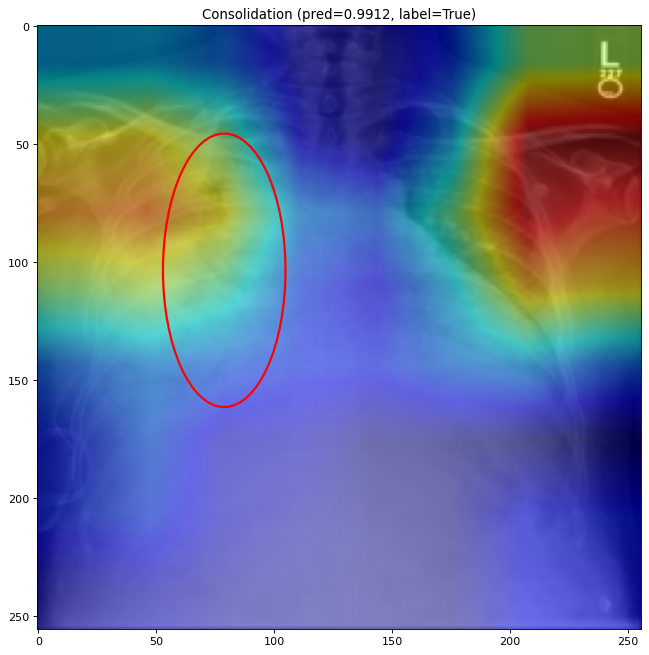

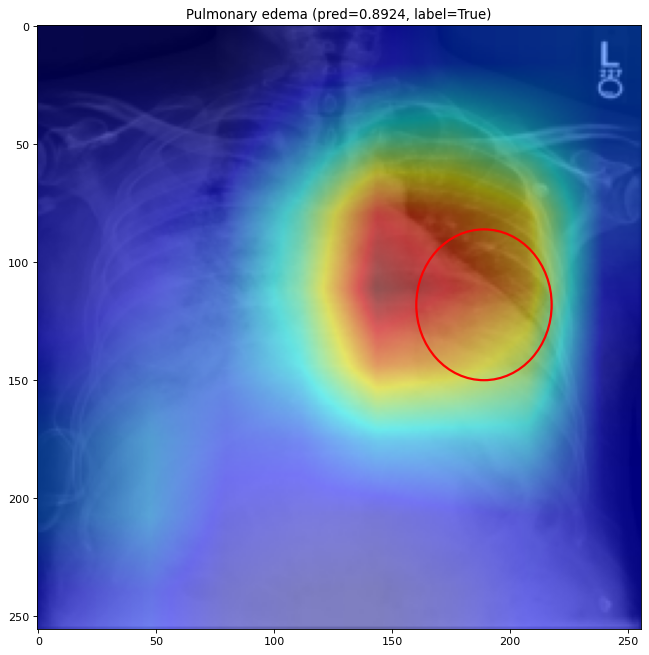

In [69]:
plot_predicting_info(cxr_model, cxr_print_idxs, loss_fn)